# Task 2 (credit card)

Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

## Импорт библиотек

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

sns.set()

## Немного о датасете 

Набор данных содержит транзакции, совершенные европейскими держателями карт по кредитным картам в сентябре 2013 года.
В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас есть 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA (Principal Component Analysis). К сожалению, по соображениям конфиденциальности мы не можем предоставить исходные признаки и более подробную информацию о данных. Признаки V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные признаки, которые не были преобразованы с помощью PCA, - это `Time` и `Amount`.

* Признак `Time` содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.
* Признак `Amount` - это сумма транзакции, этот признак может быть использован для обучения с учетом затрат в зависимости от примера.
* Признак `Class` является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.




## Обработка данных

In [32]:
df = pd.read_csv('creditcard.csv')

In [33]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [34]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Проверка на пропуски 

In [35]:
nan = df.isna().sum().sum()
print(f'Количество значений NaN: {nan}')

Количество значений NaN: 0


Пропусков нет

### Удаление дубликатов

In [36]:
len_df = len(df)
df.drop_duplicates(inplace=True)
duplicates = len_df - len(df)
print(f"Количество дубликатов: {duplicates}")

Количество дубликатов: 1081


### Сбалансированность

In [37]:
percent = round(df.Class.value_counts()[1] / df.shape[0] * 100, 3)
print(f'Процент мошеннических операций: {percent}%')

Процент мошеннических операций: 0.167%


### Основные статистики признаков

In [38]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### Есть ли сильно коррелирующие значения

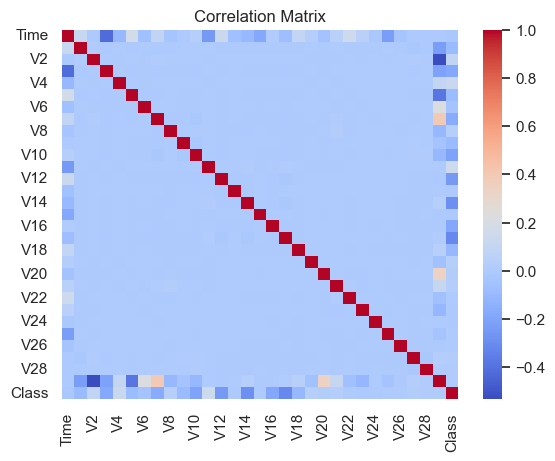

In [39]:
sns.heatmap(df.corr(), cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

В целом можно отметить, что параметры V1-V28 коррелируют в той или иной степени с признаками `Time` и `Amount`

Далее рассмотрим взаимозависимости критериев

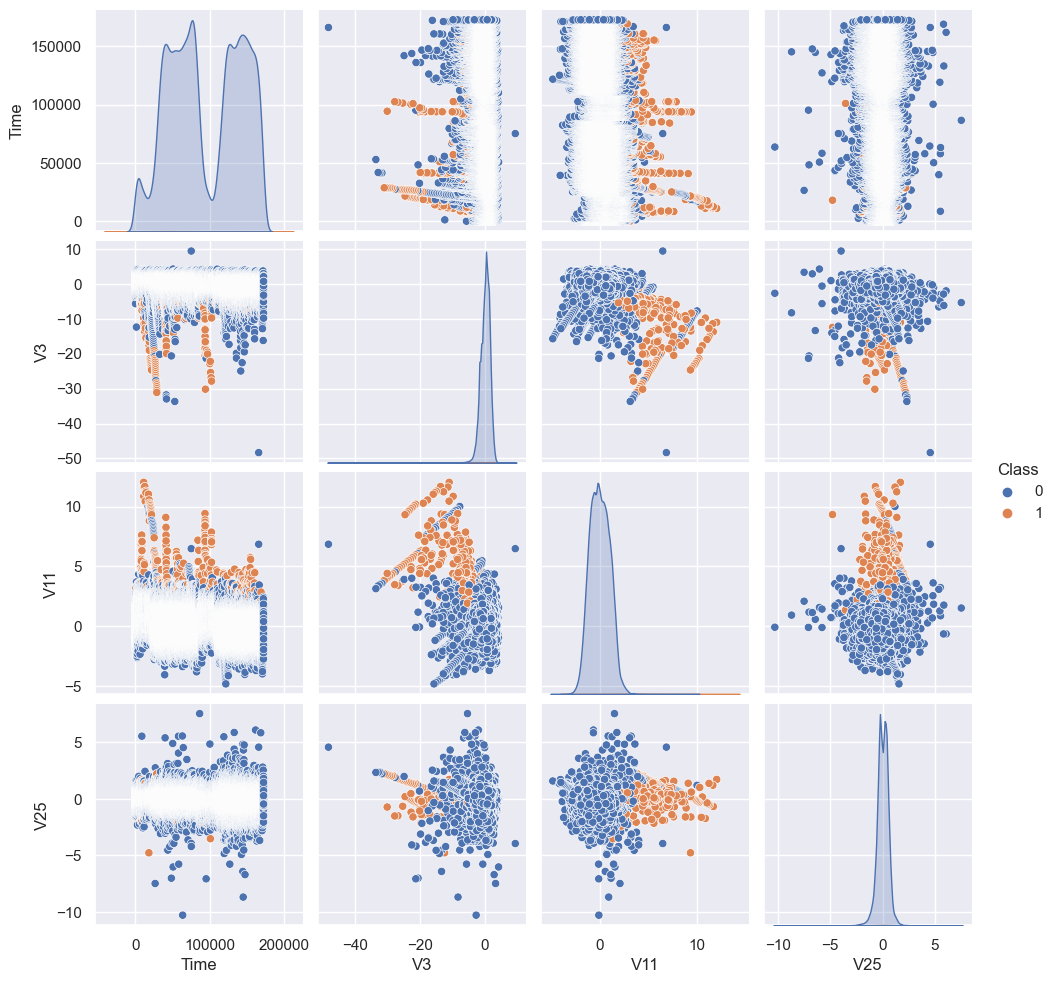

In [40]:
selected_features = ['Time', 'V3', 'V11', 'V25']
data_subset = df[selected_features + ['Class']]
sns.pairplot(data_subset, hue='Class', diag_kind='kde')
plt.show()

Как можно заметить, во многих случаях зависимости нелинейные.

<Axes: >

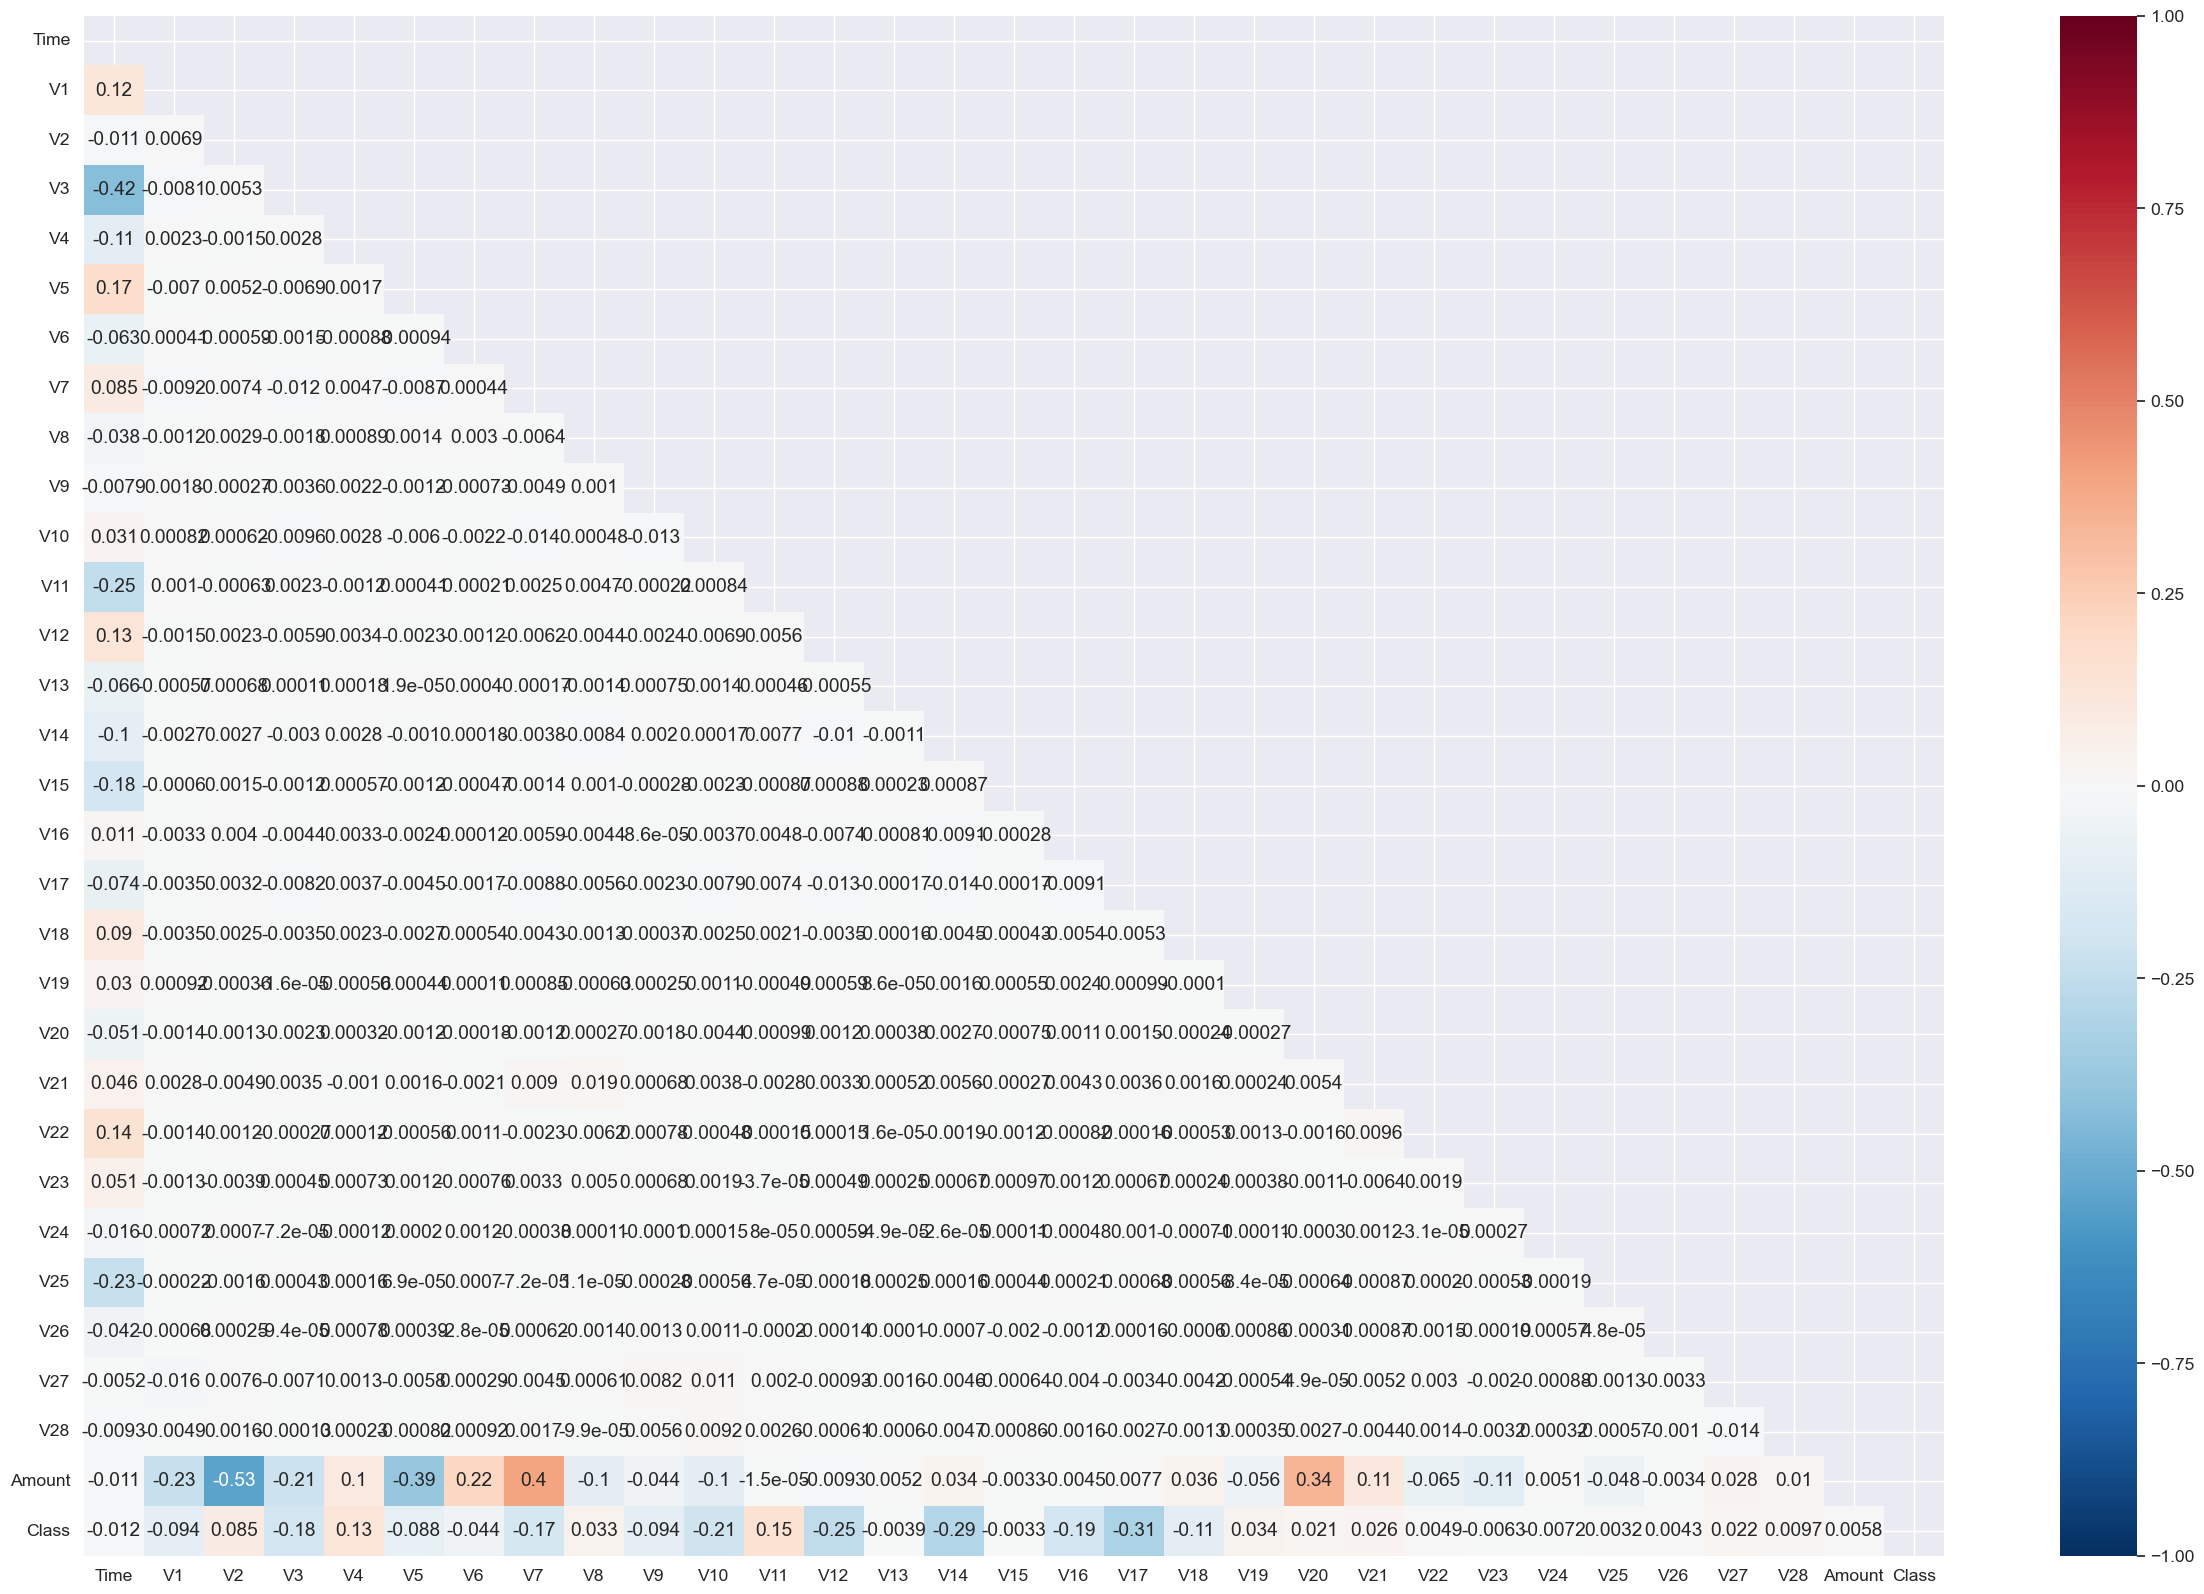

In [41]:
plt.figure(figsize=(30,20))
sns.set(font_scale=1.15)
sns.heatmap(df.corr(),
            cmap='RdBu_r', # задаёт цветовую схему
            annot=True, # рисует значения внутри ячеек
            vmin=-1, vmax=1,
            mask=np.triu(df.corr()))

Данный график подтверждает указанные выше замечания. В датасете критерии плохо коррелируют друг с другом. Однако, к-т корреляции между V1-V28 и критериями `Time` и `Amount`, больше, чем между остальными выличинами. 

Также видно, что признаки V1 - V28 в большинстве своем имеют связь с целевой переменной.

# LogisticRegression

Логистическая регрессия - один из базовых алгоритмов машинного обучения, популярна в задачах классификации. Удобна для работы с несбалансированными датасетами. Поэтому стоит вначале ею воспользоваться

In [52]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


In [53]:
df['Class'].value_counts() 


0    283253
1       473
Name: Class, dtype: int64

In [54]:
X = df.drop(['Class'], axis = 1)
y = df.Class

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [56]:
percent_train = round(y_train.value_counts()[1] / y_train.shape[0] * 100, 3)
percent_test = round(y_test.value_counts()[1] / y_test.shape[0] * 100, 3)
print(f'Процент мошеннических операций в обучающей части: {percent_train}')
print(f'Процент мошеннических операций в тестовой: {percent_test}')

Процент мошеннических операций в обучающей части: 0.167
Процент мошеннических операций в тестовой: 0.167


In [57]:
X_train.describe() - X_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,0.000539,...,0.003275,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402
std,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,-0.013638,...,0.003078,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570
min,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,-3.639071,...,0.275230,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188
25%,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,0.003933,...,0.002213,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122
50%,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,-0.001274,...,0.006274,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847
75%,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,0.007955,...,0.004499,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940
max,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,10.100677,...,-0.019858,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087


Нормализуем данные

In [58]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

Создание и обучение модели

In [59]:
LR_st = LogisticRegression(class_weight='balanced')
LR_st.fit(X_train_normalized, y_train);

In [60]:
y_pred = LR_st.predict(X_test_normalized)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



## RandomForestClassifier

Рассматривается другой алгоритм для обучение модели. Данный алгоритм хорошо работает с поиском сложных зависимостей данных

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
X = df.drop(['Class'], axis = 1)
y = df.Class

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [97]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [98]:
RFC_st = RandomForestClassifier(random_state=42, n_jobs=-1)
RFC_st.fit(X_train_normalized, y_train);

In [99]:
y_pred = RFC_st.predict(X_test_normalized)

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.77      0.85       142

    accuracy                           1.00     85118
   macro avg       0.98      0.88      0.93     85118
weighted avg       1.00      1.00      1.00     85118



## SVM-модель

In [12]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [80]:
from sklearn.svm import LinearSVC
linear_svc_st = LinearSVC( tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, verbose=0, random_state=None, max_iter=1000)
linear_svc_st.fit(X_train_normalized, y_train)
y_pred = linear_svc_st.predict(X_test_normalized)

C:\Users\tjuni\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\tjuni\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.87      0.67      0.76       142

    accuracy                           1.00     85118
   macro avg       0.94      0.83      0.88     85118
weighted avg       1.00      1.00      1.00     85118



In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.88      0.16      0.27       142

    accuracy                           1.00     85118
   macro avg       0.94      0.58      0.64     85118
weighted avg       1.00      1.00      1.00     85118



## kNN - модель

In [82]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [83]:
 from sklearn.neighbors import KNeighborsClassifier

In [84]:
knn_st = KNeighborsClassifier(n_neighbors=5)


In [85]:
knn_st.fit(X_train_normalized, y_train)
y_pred = knn_st.predict(X_test_normalized)

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.94      0.71      0.81       142

    accuracy                           1.00     85118
   macro avg       0.97      0.86      0.90     85118
weighted avg       1.00      1.00      1.00     85118



## Обучение на сэмплированных данных

In [63]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

Before OverSampling, counts of label '1': 331
Before OverSampling, counts of label '0': 198277 



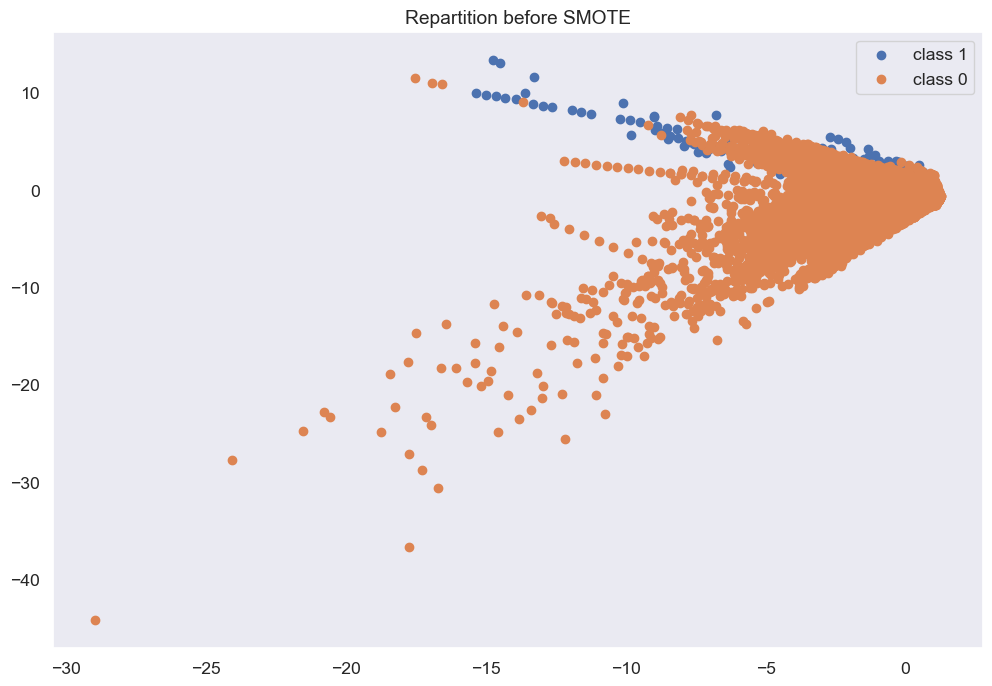

In [64]:
plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(X_train_normalized[y_train==1][:, 0], X_train_normalized[y_train==1][:, 1], label='class 1')
plt.scatter(X_train_normalized[y_train==0][:, 0], X_train_normalized[y_train==0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

In [65]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy='auto', random_state = 2) 
X_train_res, y_train_res = sm.fit_resample(X_train_normalized, y_train.ravel())

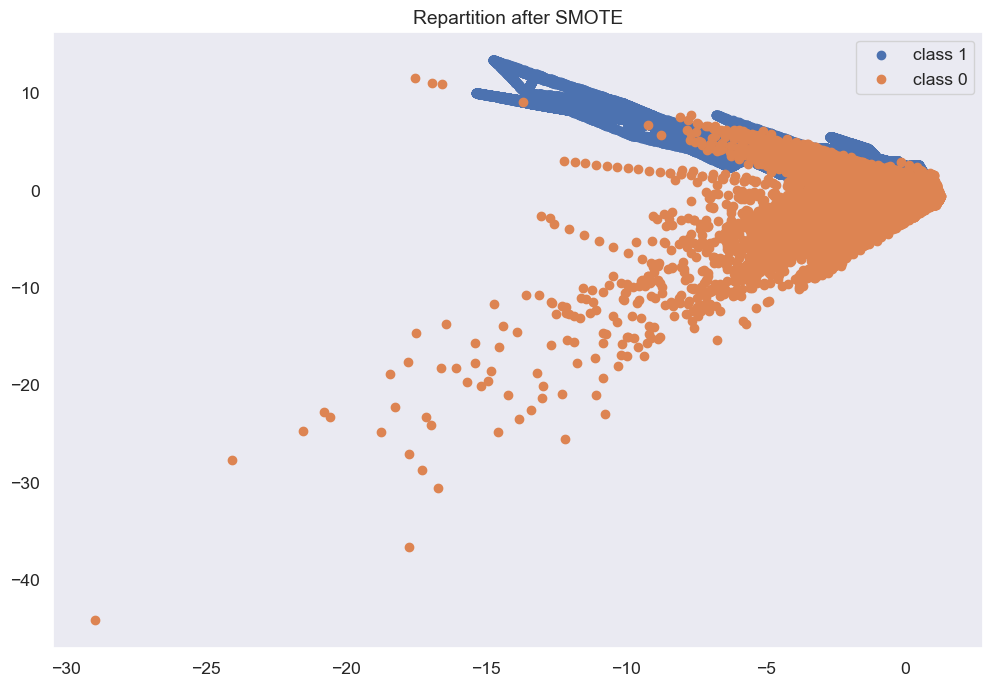

In [66]:
plt.figure(figsize=(12, 8))
plt.title('Repartition after SMOTE')
plt.scatter(X_train_res[y_train_res==1][:, 0], X_train_res[y_train_res==1][:, 1], label='class 1')
plt.scatter(X_train_res[y_train_res==0][:, 0], X_train_res[y_train_res==0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

In [35]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (396554, 28)
After OverSampling, the shape of train_y: (396554,) 

After OverSampling, counts of label '1': 198277
After OverSampling, counts of label '0': 198277


# LogisticRegression

In [67]:
LR = LogisticRegression(class_weight='balanced')
LR.fit(X_train_res, y_train_res);

In [68]:
y_pred = LR.predict(X_test_normalized)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     84976
           1       0.05      0.89      0.09       142

    accuracy                           0.97     85118
   macro avg       0.52      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



## RandomForestClassifier

In [70]:
RFC = RandomForestClassifier(random_state=42, n_jobs=-1)
RFC.fit(X_train_res, y_train_res.ravel());

In [71]:
y_pred = RFC.predict(X_test_normalized)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.89      0.75      0.81       142

    accuracy                           1.00     85118
   macro avg       0.95      0.87      0.91     85118
weighted avg       1.00      1.00      1.00     85118



## SVM-модель

In [77]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC( tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, verbose=0, random_state=None, max_iter=1000)
linear_svc.fit(X_train_res, y_train_res)
y_pred = linear_svc.predict(X_test_normalized)

C:\Users\tjuni\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\tjuni\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.89      0.11       142

    accuracy                           0.98     85118
   macro avg       0.53      0.93      0.55     85118
weighted avg       1.00      0.98      0.99     85118



## kNN - модель

In [88]:
knn = KNeighborsClassifier(n_neighbors=5)

In [89]:
knn.fit(X_train_res, y_train_res.ravel())
y_pred = knn.predict(X_test_normalized)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.45      0.80      0.58       142

    accuracy                           1.00     85118
   macro avg       0.73      0.90      0.79     85118
weighted avg       1.00      1.00      1.00     85118



In [92]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
)


# Defining a function to evaluate the model and display metrics
def evaluate(model, conf_matrix=True, return_=False):
    # Confusion Matrix
    y_pred = model.predict(X_test_normalized)
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]

    # Displaying the Confusion Matrix if specified
    if conf_matrix:
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Displaying the Classification Report
    print(classification_report(y_test, y_pred))

    # Calculating and displaying additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Displaying the summary metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")

    # Extracting the model name for display
    model_name = str(type(model).__name__)

    # Returning metrics as a dictionary if specified
    if return_:
        metrics_dict = {
            "Model": model_name,
            "accuracy": round(accuracy, 3),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1": round(f1, 3),
            "roc_auc": round(roc_auc, 3),
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
        }
        return metrics_dict

In [101]:
classifiers = [LR_st, RFC_st, linear_svc_st, knn_st,  LR, RFC, linear_svc, knn]

dfs = []
for classifier in classifiers:
    metrics_result = evaluate(classifier, return_=True, conf_matrix=False)

    metrics_df = pd.DataFrame([metrics_result])

    dfs.append(metrics_df)

results_df = pd.concat(dfs, ignore_index=True)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118

Accuracy: 0.972
Precision: 0.051
Recall: 0.887
F1-Score: 0.096
ROC-AUC: 0.930
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.77      0.85       142

    accuracy                           1.00     85118
   macro avg       0.98      0.88      0.93     85118
weighted avg       1.00      1.00      1.00     85118

Accuracy: 1.000
Precision: 0.965
Recall: 0.768
F1-Score: 0.855
ROC-AUC: 0.884
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.87      0.67      0.76       142

    accuracy              

## Таблица с результатами

In [102]:
results_df

,Model,accuracy,precision,recall,f1,roc_auc,tp,tn,fp,fn
0,LogisticRegression,0.972,0.051,0.887,0.096,0.930,82624,126,2352,16
1,RandomForestClassifier,1.000,0.965,0.768,0.855,0.884,84972,109,4,33
2,LinearSVC,0.999,0.872,0.669,0.757,0.834,84962,95,14,47
3,KNeighborsClassifier,0.999,0.935,0.711,0.808,0.856,84969,101,7,41
4,LogisticRegression,0.970,0.047,0.887,0.090,0.929,82446,126,2530,16
5,RandomForestClassifier,0.999,0.891,0.746,0.812,0.873,84963,106,13,36
6,LinearSVC,0.976,0.059,0.887,0.111,0.932,82973,126,2003,16
7,KNeighborsClassifier,0.998,0.452,0.803,0.579,0.901,84838,114,138,28


## Выводы 

По итогу данной работы были обучены две модели для обнаружение мошенничества с кредитными картами

Использовались следующие модели: `LogisticRegression`, `RandomForestClassifier`, `Support Vector Machines - method`, `KNN - method`

Также были получены метрики результатов предсказаний моделей. Основные метрики для анализа предсказания: `precision` и `recall`, которые можно наблюдать в таблице. Стоит отметить следующие факты:
1) Для всех использованных моделей оверсэмплинг с помощью алгоритма `Smote` не дает положительный прирост в точности;
2) Самым подходящим среди используемых моделей для поставленной задачи является `RandomForestClassifier`, однако модели `Support Vector Machines - method`, `KNN - method`- тоже показали хорошие результаты, если рассматривать данные без сэмплинга.

В заключение следует сделать выводы:
* рассмотреть другие алгоритмы семплинга, так как для данного датасета алгоритм оверсэмплинга SMOTE не дает улучшение точности.
* проварьировать гиперпараметры моделей

